# EE5175 Lab 3 : Image mosaicing
### Author : Niyas Mon P
### Roll No: EE20B094


#### Input : img1.png, img2.png and img3.png
#### Task  : Determine the geometric transformations (homographies) between these images and stitch them into a single image.
#### Output : Mosaiced image

In [ ]:
#  Before running the code blocks, please ensure all the images are uploaded

In [92]:
# importing necessary libraries
from google.colab.patches import cv2_imshow
from sift import sift as sift_corresp
from scipy.linalg import null_space
from random import randint
import numpy as np
import cv2

Concatenated image


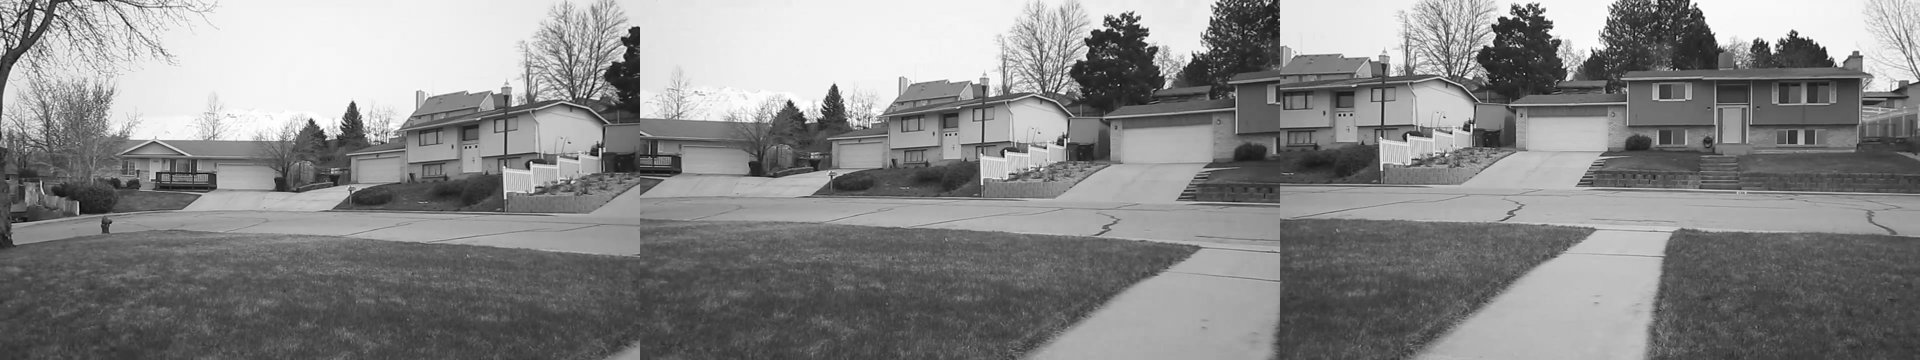

In [93]:
# reading the images
img1 = cv2.imread('img1.png')
img2 = cv2.imread('img2.png')
img3 = cv2.imread('img3.png')
image_concatenated = np.concatenate((img1, img2, img3), axis=1)

# displaying the 3 images together
print("Concatenated image")
cv2_imshow(image_concatenated)

The given images are gray scale images but still have 3 channels with gray scale values. But we need only one channel hence we slice the image reducing the dimension from 3 to 2

In [94]:
# convert image from 3 channel to 1 channel image. cause, it is in gray scale
img1 = img1[:,:,0]
img2 = img2[:,:,0]
img3 = img3[:,:,0]

## RANSAC
### Following 3 function are used in RANSAC algorithm
* pick_random_index   : inorder to pick random 4 points
* calculate_h         : to calculate h vector from 4 point-correspondance
* error : to calculate error in the estimation of pixels using H

1) SIFT function givens the correspondance set \\
2) 4 random point-correspondance are taken using pick_random_index function \\
3)The  correspondance matrix is computed as follows:

\\
\begin{align*}
A =
\begin{bmatrix}
-x_1 & -y_1 & -1 & 0 & 0 & 0 & x_1 \cdot  x_1' & x_1' \cdot y_1 & x_1'\\
0 & 0 & 0 & -x_1 & -y_1 & -1 & y_1' \cdot  x_1 & y_1' \cdot y_1 & y_1'\\
-x_2 & -y_2 & -1 & 0 & 0 & 0 & x_2 \cdot  x_2' & x_2' \cdot y_2 & x_2'\\
0 & 0 & 0 & -x_2 & -y_2 & -1 & y_2' \cdot  x_2 & y_2' \cdot y_2 & y_2'\\
-x_3 & -y_3 & -1 & 0 & 0 & 0 & x_3 \cdot  x_3' & x_3' \cdot y_3 & x_3'\\
0 & 0 & 0 & -x_3 & -y_3 & -1 & y_3' \cdot  x_3 & y_3' \cdot y_3 & y_3'\\
-x_4 & -y_4 & -1 & 0 & 0 & 0 & x_4 \cdot  x_4' & x_4' \cdot y_4 & x_4'\\
0 & 0 & 0 & -x_4 & -y_4 & -1 & y_4' \cdot  x_4 & y_4' \cdot y_4 & y_4'\\
\end{bmatrix}
\end{align*}

\\
4) Next we will solve the equation using nullity:
\begin{align*}
A \cdot
\begin{bmatrix}
h_{11} \\
h_{12} \\
h_{13} \\
h_{21} \\
h_{22} \\
h_{23} \\
h_{31} \\
h_{32} \\
h_{33} \\
\end{bmatrix}
 = \textbf{0}
\end{align*}

\\
5) Rearranging it to create Homography matrix:
\begin{align*}
H =
\begin{bmatrix}
h_{11} &
h_{12} &
h_{13} \\
h_{21} &
h_{22} &
h_{23} \\
h_{31} &
h_{32} &
h_{33} \\
\end{bmatrix}
\end{align*}

\\
6) Using this H, we calculate the errors in the remaining points in the correspondance set and run the remaining steps of RANSAC as given in the question.

In [128]:
# function to pick random integers form a range
def pick_random_index(len,start,end):
  random_index = []
  for i in range(len):
    random_integer = randint(0, end)
    while random_integer in random_index:
      random_integer = randint(0,end)
    random_index.append(random_integer)
  return random_index




# function to calculate the h vector from the 4 point corresponance using nullity
def calculate_h(rand_index,corr1,corr2):
  # chosing 4 point-correspondances from random indices
  x1,y1,x_1,y_1 = corr2[rand_index[0]][0], corr2[rand_index[0]][1], corr1[rand_index[0]][0], corr1[rand_index[0]][1]
  x2,y2,x_2,y_2 = corr2[rand_index[1]][0], corr2[rand_index[1]][1], corr1[rand_index[1]][0], corr1[rand_index[1]][1]
  x3,y3,x_3,y_3 = corr2[rand_index[2]][0], corr2[rand_index[2]][1], corr1[rand_index[2]][0], corr1[rand_index[2]][1]
  x4,y4,x_4,y_4 = corr2[rand_index[3]][0], corr2[rand_index[3]][1], corr1[rand_index[3]][0], corr1[rand_index[3]][1]

  # creating the 4 point-correspondance matrix
  A = np.array([[-x1,-y1,-1,0,0,0,x1*x_1,x_1*y1,x_1],
               [0,0,0,-x1,-y1,-1,y_1*x1,y_1*y1,y_1],
               [-x2,-y2,-1,0,0,0,x2*x_2,x_2*y2,x_2],
               [0,0,0,-x2,-y2,-1,y_2*x2,y_2*y2,y_2],
               [-x3,-y3,-1,0,0,0,x3*x_3,x_3*y3,x_3],
               [0,0,0,-x3,-y3,-1,y_3*x3,y_3*y3,y_3],
               [-x4,-y4,-1,0,0,0,x4*x_4,x_4*y4,x_4],
               [0,0,0,-x4,-y4,-1,y_4*x4,y_4*y4,y_4]])

  # solving for 'h' by nulltiy | A*h = 0
  h = null_space(A)
  # if it returns more than one null space, then choose the first one
  if h.shape[1] >1:
    h = h[:,0]

  return h



# function to calculate error
def error(x1,x2,y1,y2):
  err = np.sqrt((x1-x2)**2 + (y1-y2)**2)
  return err


In [158]:
# RANSAC algorithm
def RANSAC(corr1,corr2):
  M = len(corr1)

  while True:
    # randomly picking 4 points
    rand_index = pick_random_index(len=4,start=0,end=M-1)
    # calculating Homography using the 4 points chosen
    h = calculate_h(rand_index,corr1,corr2)
    H = np.array([[h[0],h[1],h[2]],
                 [h[3],h[4],h[5]],
                 [h[6],h[7],h[8]]])
    H = H.reshape(3, 3)

    cons = []   # consensus set

    for i in range(M): # for all points in correspondance set
      if i not in rand_index:  # except the randonly chosen 4

        x,y              = corr2[i][0], corr2[i][1]
        x1,y1            = corr1[i][0], corr1[i][1]

        # finding the mapped coordinated (x'',y'')
        mapped_vals      = np.dot(H,np.array([x,y,1]))
        x_map, y_map, zz = mapped_vals[0], mapped_vals[1], mapped_vals[2]
        # normalizing
        x_map            = x_map/zz
        y_map            = y_map/zz

        # if error is less than 10, add the index to the consensus set
        err              = error(x1,x_map,y1,y_map)
        # print(err)
        if err<10:
          cons.append(i)

    # if consensus set is larger than 80% of the remaining points, then break the loop and return H
    # else go back and do again
    if len(cons) > 0.8 * (M-4):
      break
  return H


#### Source to target mapping using bilinear interpolation
\begin{align*}
\begin{bmatrix}
x_t \\
y_t \\
1\\
\end{bmatrix}
=
H
\begin{bmatrix}
x_s \\
y_s \\
1\\
\end{bmatrix}
\end{align*}
\begin{align*}\\
\begin{bmatrix}
x_s \\
y_s \\
1\\
\end{bmatrix}
=
H^{-1}
\begin{bmatrix}
x_t \\
y_t \\
1\\
\end{bmatrix}
\end{align*}

\begin{align*}\\
a &= x_s - \lfloor x_s \rfloor \\
b &= y_s - \lfloor y_s \rfloor
\end{align*}
Using bilinear interpolation,

<font size="-1">
\begin{align*}\\
I_t(x_t,y_t) &= (1-a) \cdot (1-b) \cdot I_s(\lfloor x_s \rfloor,\lfloor y_s \rfloor) + (1-a) \cdot b \cdot I_s(\lfloor x_s \rfloor,\lfloor y_s \rfloor + 1) + a \cdot (1-b) \cdot I_s(\lfloor x_s \rfloor + 1,\lfloor y_s \rfloor) + a \cdot b \cdot I_s(\lfloor x_s \rfloor + 1,\lfloor y_s \rfloor + 1) \\
\end{align*}


In [85]:
# biliear interpolation function
def bilin_interpol(image , xs , ys ):

  height, width     = image.shape[0], image.shape[1]

  target_intensity  = 0 # the intensity at the target coordinate

  # floor values of source pixel coordinates
  xs_f = int(np.floor(xs))
  ys_f = int(np.floor(ys))

  a    = xs - xs_f
  b    = ys - ys_f

  # Source to target mapping using bilinear interpolation
  if (ys_f < width-1) & (xs_f <height-1) & (ys_f > 0) & (xs_f > 0): # update only if sourse pixels falls within the range else remains as blank
    target_intensity = (1-a)*(1-b)*image[xs_f ,ys_f] + (1-a)*(b)*image[xs_f+1,ys_f] + a*(1-b)*image[xs_f,ys_f+1] + (a*b)*image[xs_f+1,ys_f+1]

  return target_intensity


### Mosaicing

* A big canvas is created whose dimensions are 3 times that of a single image.
* For each point in the canvas (target), we calculate the corresponding points in the 3 images (source) using source to target mapping and applying bilear interpolation.
* Blending: In the overlapping regions in the target, we take **average** of the pixel intensities mapped to the same location.
* The 2nd image is taken as reference and hence inorder to bring the mosaiced image to the centre of canvas, offset is used in both dimensions which puts the 2nd image to the centre of canvas.
* Offset values are $(1/3)^{rd}$ of the dimensions of the canvas

In [123]:
def mosaic(img1,img2,img3):

  # running SIFT between image 1 & 2 and image 3 & 2
  [corr1, corr2]      = sift_corresp(img1,img2)
  [corr3, corr4]      = sift_corresp(img3,img2)

  # finding the homography between image 1 & 2 and image 3 & 2 using RANSAC algorithm
  H21                 = RANSAC(corr1,corr2)
  H23                 = RANSAC(corr3,corr4)

  # height & width of a single image
  ht , wd             = img1.shape[0], img1.shape[1]
  # canvas height and width : 3 times that of a single image
  can_ht , can_wd     = 3*ht, 3*wd

  canvas=np.zeros((can_ht,can_wd))

  # offset so that the mosaiced image is fit at the centre.
  # keeps the 2nd image in the middle of canvas
  offset_row          = can_wd//3
  offset_column       = can_ht//3

  # running over each pixels in canvas
  for jj in range(0,can_wd):
    for ii in range(0,can_ht):

      j               = jj-offset_row
      i               = ii-offset_column

      # target(image2) to source(image1) mapping
      xs1,ys1,z1      = np.dot(H21, np.array([i,j,1]))
      # normalizing
      xs1             = xs1/z1
      ys1             = ys1/z1

      # target(image2) to source(image3) mapping
      xs2,ys2,z2      = np.dot(H23, np.array([i,j,1]))
      # normalizing
      xs2             = xs2/z2
      ys2             = ys2/z2


      # bilinear interpolated intensity values from each images
      intensity1      = bilin_interpol(img1,xs1,ys1)
      intensity2      = bilin_interpol(img2,i,j)
      intensity3      = bilin_interpol(img3,xs2,ys2)

      # Blending
      arr = np.array([intensity1,intensity2,intensity3])
      num_overlap     = np.count_nonzero(arr)
      if num_overlap>0:
        canvas[ii,jj] = (intensity1+intensity2+intensity3)/num_overlap

  return canvas

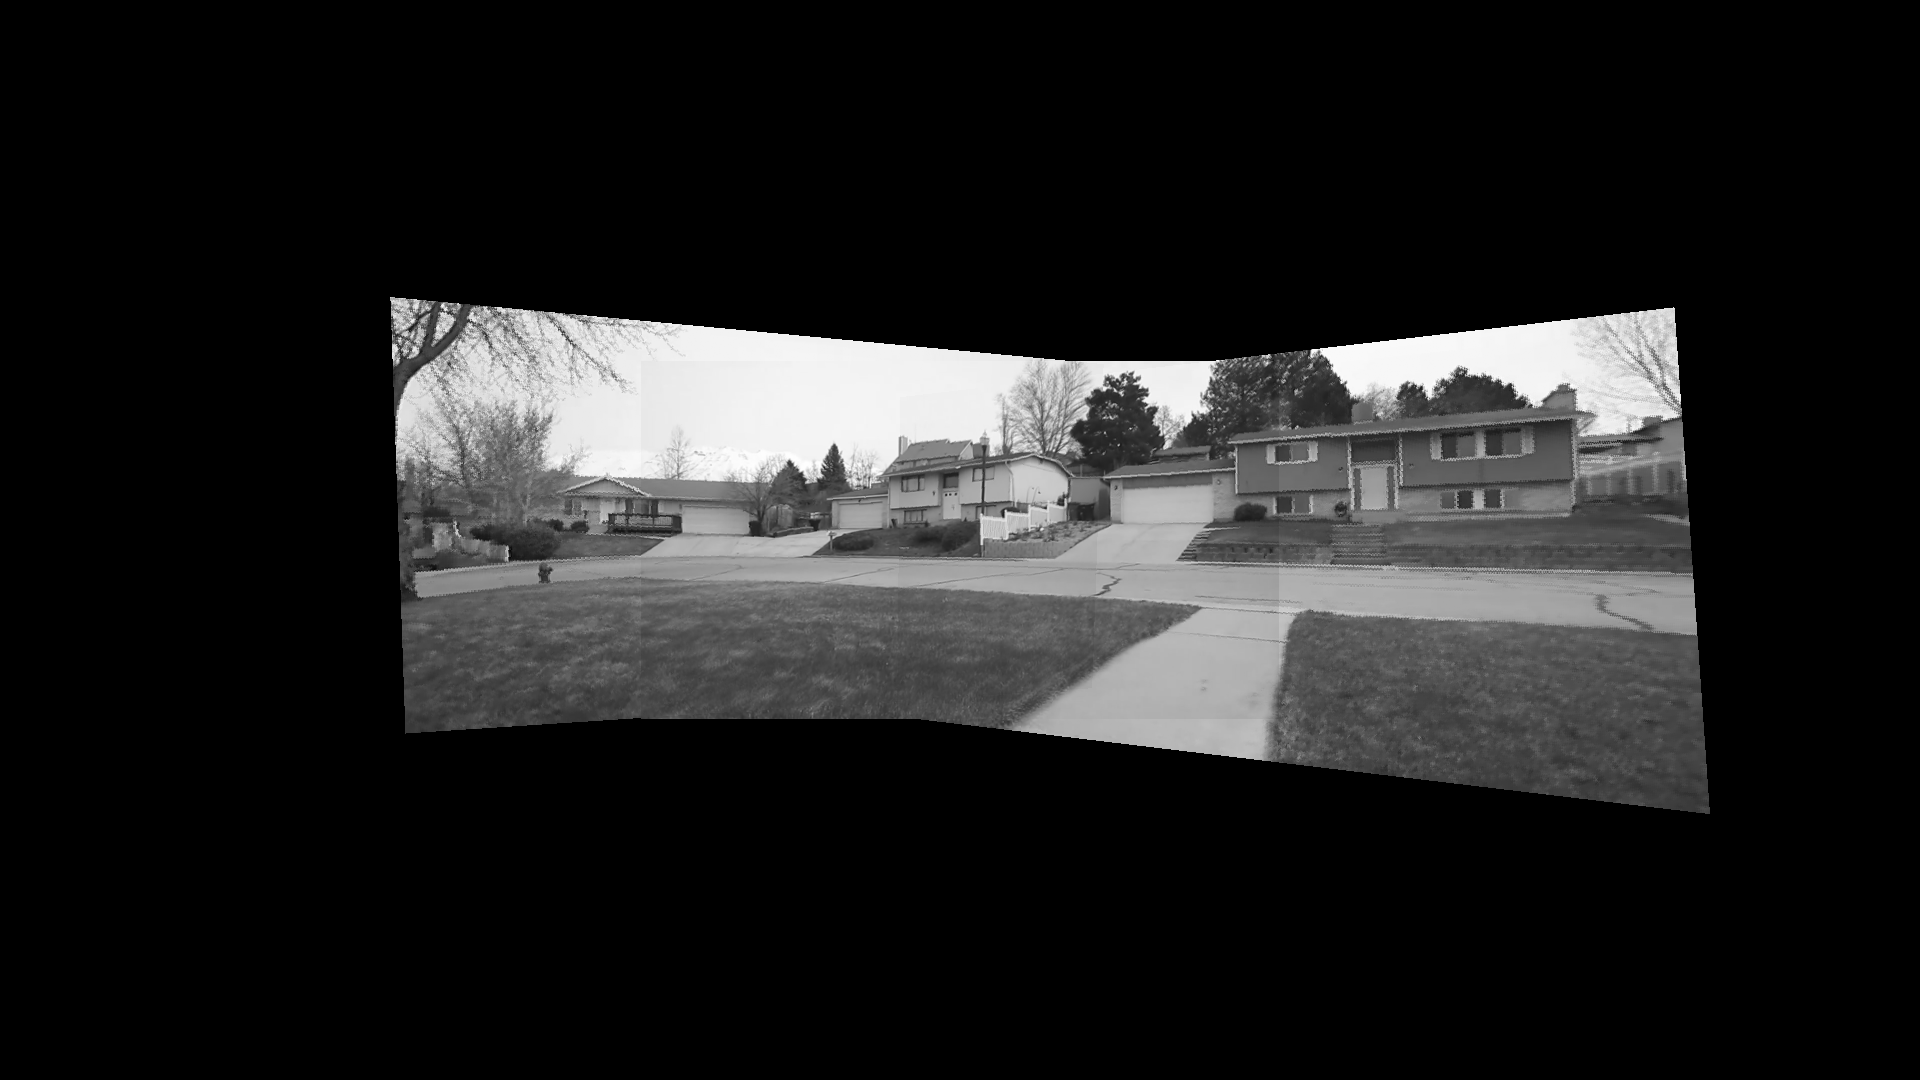

In [157]:
cv2_imshow(mosaic(img1,img2,img3))

# Capturing our own data

#### The images captured from the football ground near ChemPlast

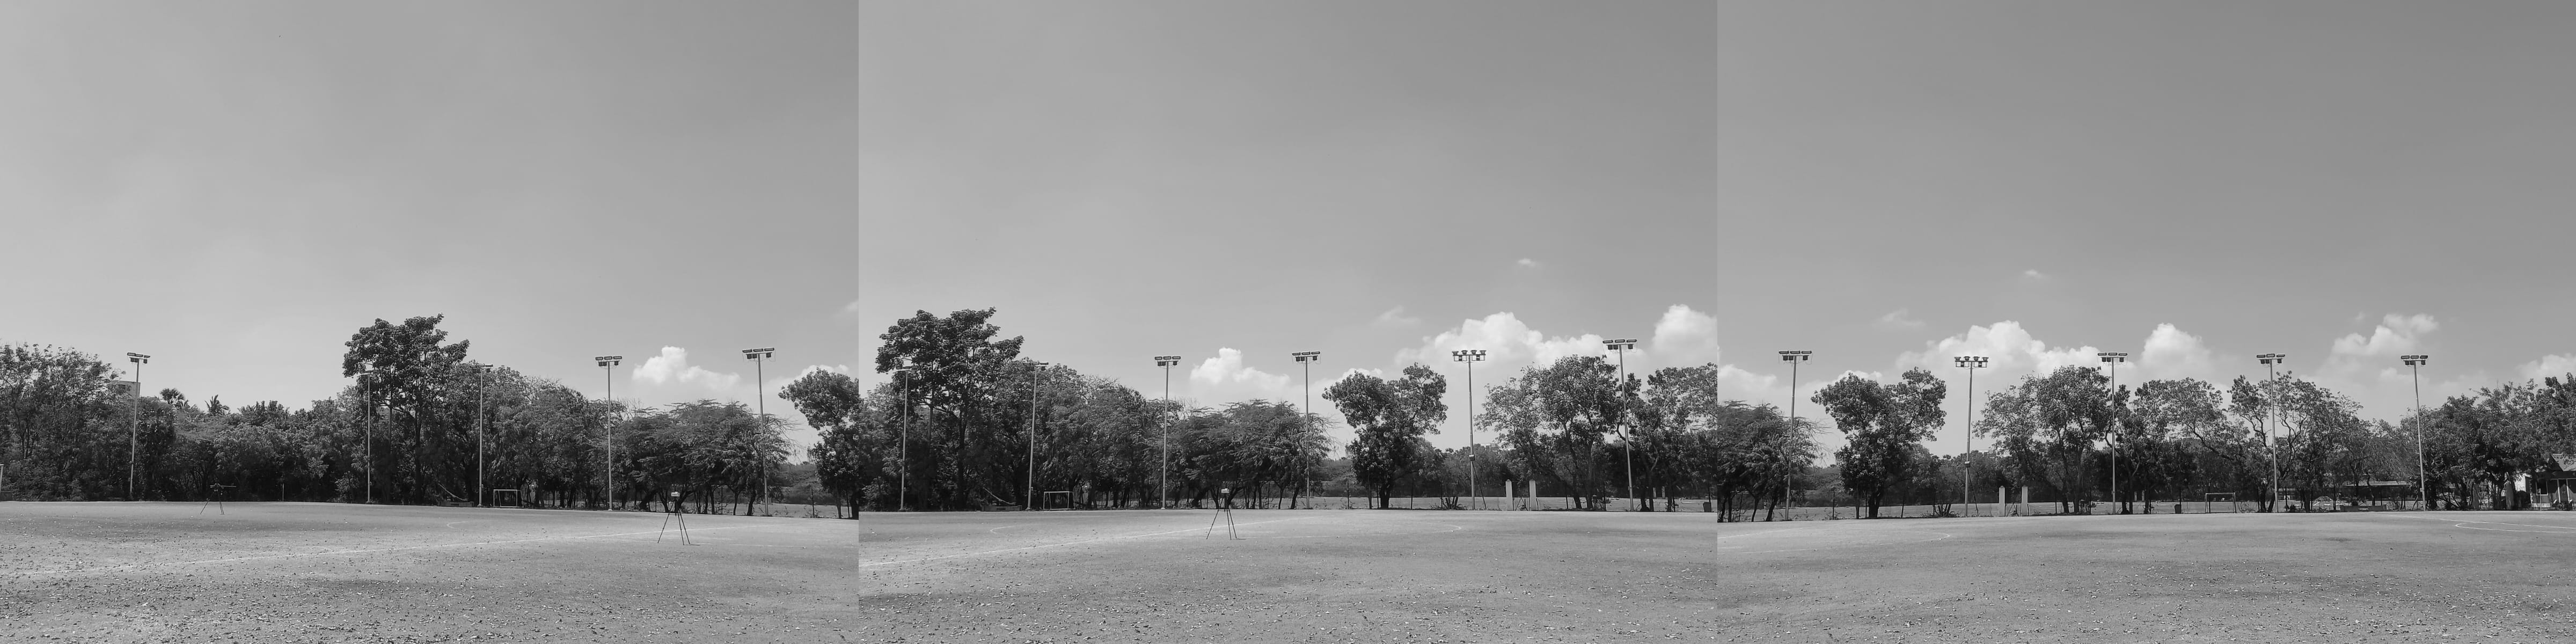

In [135]:
i1 = cv2.imread('i1.jpeg')
i2 = cv2.imread('i2.jpeg')
i3 = cv2.imread('i3.jpeg')

# conerting the images to gray scale
i1 = cv2.cvtColor(i1, cv2.COLOR_BGR2GRAY)
i2 = cv2.cvtColor(i2, cv2.COLOR_BGR2GRAY)
i3 = cv2.cvtColor(i3, cv2.COLOR_BGR2GRAY)

# displaying the 3 images together
image_concatenated2 = np.concatenate((i1, i2, i3), axis=1)
# print("Concatenated image")
cv2_imshow(image_concatenated2)

In [118]:
i1.shape

(1200, 1600)

The resolution of the images is higher and hence bringing it down to (600, 800)

In [119]:
# bringing the resolution of images from (1200, 1600) to (600, 800)
ht, wd = i1.shape
new_ht, new_wd = ht//2, wd//2
i1 = cv2.resize(i1, (new_wd,new_ht))
i2 = cv2.resize(i2, (new_wd,new_ht))
i3 = cv2.resize(i3, (new_wd,new_ht))

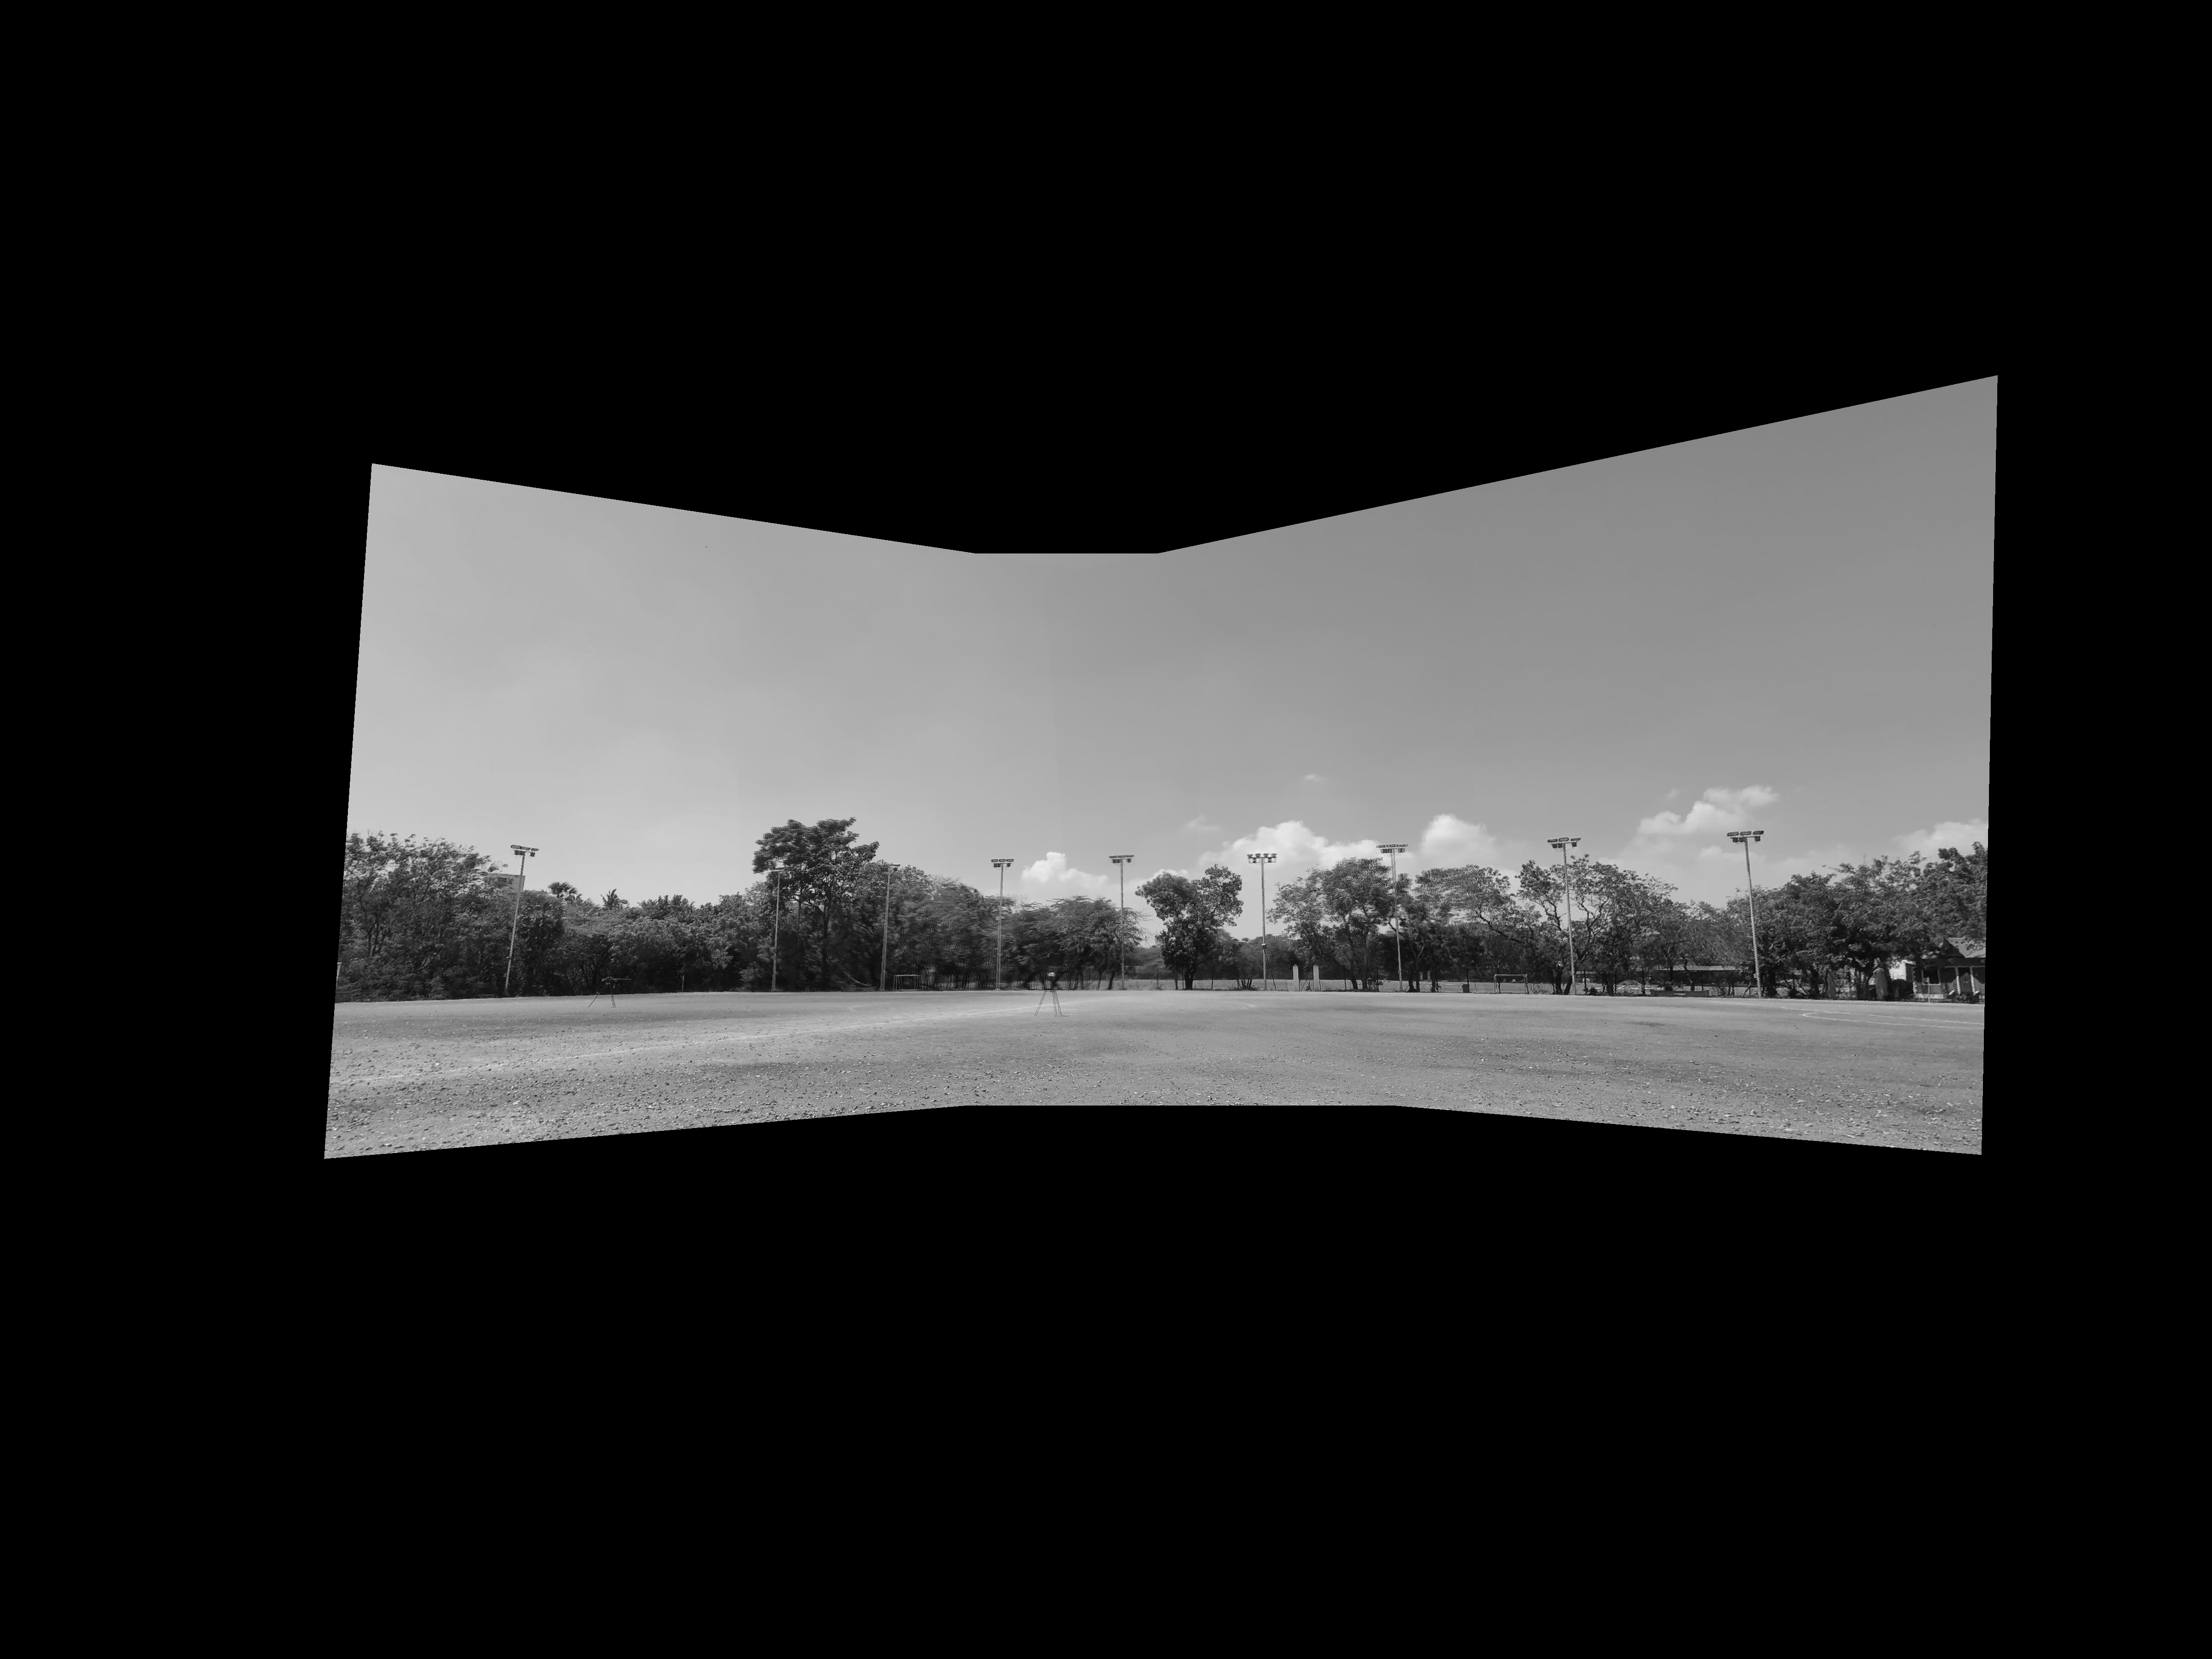

In [151]:
cv2_imshow(mosaic(i1,i2,i3))

## Inferences


*   Sufficient overlap should be there between the images inorder to get sufficient correspondance points and good homography
* RANSAC is used to remove outliers and find the homography between two images.
*   The mosaic image has blurring at the overlaping regions due to blendng.
*   The blend is done by averaging the intensities in the overlapping regions.
*   The image is taken from sufficiently far away inorder to make sure that the scene is planar.
*   Increasing the number of pixels will cause the run time to increase hence and larger resolution images, we bring it bring it down to smaller resolution before mosaicing.

